# Проектна задача по предметот „Мобилна роботика“
## Теодора Петровска, 98/2021
#### Во оваа тетратка е решен проблемот на LunarLander од OpenAI Gym

Импортирање на потребните библиотеки

In [1]:
import random
import statistics
from collections import deque
import threading
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.animation as animation

Дефинирање на хиперпараметрите
- ALPHA: стапка на учење, колку брзо учи моделот
- GAMMA: фактор на дисконтирање, ги балансира краткотрајните и долготрајните награди. 0.99 значи дека битни ни се идните награди
- EPSILON*: го контролира истражувањето на агентот. Почни случајно да истражуваш, стани алчен со тек на време
- BATCH SIZE: од колку примероци да учи одеднаш
- BUFFER CAPACITY: максимална големина на меморијата
- TARGET UPDATE FREQ: фреквенција на синхронизирање на посакуваниот модел. На секои 10 епизоди ги копираме (синхронизираме) тежините од policy_net (онаа што учи) до target_net (онаа што се користи за пресметување на целната Q-вредност).

In [2]:
ALPHA = 1e-3
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
BATCH_SIZE = 64
BUFFER_CAPACITY = 100_000
TARGET_UPDATE_FREQ = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Користиме Deep Q-Network (длабока Q мрежа) - вид на невронска мрежа што се користи за апроксимација на Q функцијата, којашто ни кажува колку е добро да се преземе акција а во состојба ѕ.  
Околината LunarLander-v3 се состои од 8 влезови што ја опишуваат моменталната состојба на ракетата:
- x позиција (хоризонтално)
- у позиција (вертикално)
- х брзина
- у брзина
- агол под кој е поставена ракетата
- аголна брзина (колку брзо ротира)
- контакт на левата нога (1 ако ја допира земјата, 0 ако не ја допира)
- контакт на десната нога
  
Има 4 дискретни излези:
- 0: не прави ништо
- 1: активирај го левиот мотор
- 2: активирај го главниот мотор
- 3: активирај го десниот мотор
  
Невронската мрежа се состои од следниве слоеви:
- Влезен слој 8 -> 128 неврони: ги трансформира 8-те влезни вредности во 128 димензионална репрезентација
- Скриен слој 128 -> 128: додава капацитет за учење на посложени шеми
- Излезен слој 128 -> 4: дава една Q вредност по можна акција
- Активациска функција ReLU: се користи за да се воведе нелинеарност. Ова ѝ овозможува на мрежата да учи сложени шеми

Со методот „forward“ PyTorch знае како да ја води мрежата напред: зема состојба х и дава Q вредности за секоја акција. На пример ако состојбите на ракетата се:  

x = [0.1, -0.2, 0.3, 0.05, 0.0, 0.01, 1.0, 0.0]  

Тогаш  

model = DQN(8, 4)  
output = model.forward(x)  

Ќе даде нешто вакво  

output = [1.5, -2.1, 0.3, 0.9]  

Што значи:  
Q вредност да не прави ништо: 1.5  
Q вредност да оди лево: -2.1  
Q вредност да оди надолу: 0,3  
Q вредност да оди десно: 0.9  

Агентот ќе ја избере акцијата со најголема Q вредност што во случајов е да не прави ништо.

In [3]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

Во Reinforcement Learning агентите учат од своите искуства (состојба, акција, награда, следна состојба и сл.). Но, ако учиме од нив по редоследот по којшто се случуваат, постои проблем каде што последователните искуства се многу корелирани, па, наместо веднаш да учиме, ние ги складираме искуствата во бафер и потоа случајно земаме примероци за да ја тренираме мрежата. Ова го надминува проблемот на корелација и го прави учењето поефикасно. 

Во иницијализацијата користиме deque (double-ended-queue) за да ги зачуваме искуствата. maxlen=capacity осигурува дека баферот не расте бесконечно, старите искуствата автоматски се отфрлаат кога ќе се наполни баферот.

Push методот додава едно искуство во баферот. Секое искуство е торка од 5 елементи: (state, action, reward, next_state, done). Но, со np.expand_dims додаваме дополнителна димензија на state и next_state бидејќи невронската мрежа очекува влез со облик (batch_size, input_size). На овој начин, кога ги ставаме состојбите во batch, добиваме правилен облик. Без expand_dims: [8], со expand_dims: [1,8]. Невронската мрежа бара облик [1, 8], не само [8].

Во sample случајно избираме искуства од batch_size од баферот. zip(*batch) ги дели торките во посебни листи: една листа од состојби, една од акции и сл. Ова ни овозможува да учиме од повеќе минати искуства одеднаш. Потоа, ги форматираме податоците во numpy низи за да можеме да ги конвертираме во тензори.

len(buffer) само овозможува да ја провериме големината на баферот. Ова е корисно за проверка дали имаме доволно примероци за да започнеме со тренирање.

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.concatenate(states)
        next_states = np.concatenate(next_states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

policy одлучува која акција треба да ја преземе агентот следно врз основа на моменталната состојба. Тука имаме збир на правила што агентот ги користи за да избере акции. Оваа функција е важна бидејќи агентот учи како безбедно да слета. За да научи тој понекогаш мора да:
- проба случајни акции (да истражува)
- да го користи она што го научил досега (да експлоатира)  

Оваа функција го балансира истражувањето и експлоатирањето користејќи epsilon-greedy (епсилон-алчна) стратегија.

np.random.rand() дава случаен број помеѓу 0 и 1, epsilon е број од 1 до 0,01 којшто се намалува со тек на време. Ако случајниот број е помал од epsilon избираме случајно дејство. Овој дел е истражување - пробувај нови работи дури и ако не си сигурен дека се добри.

Ако не истражуваме случајно, го користиме моделот за да одлучиме. Ја претвораме состојбата (којашто е NumPy низа) во PyTorch тензор. unsqueeze(0) додава димензија - обликот станува (1,8). Ја пренесуваме состојбата во невронската мрежа за да добиеме Q-вредности за секоја акција. Со torch.no_grad() се исклучува следењето на градиентот - ние само предвидуваме, не тренираме. q_values е тензор со 4 вредности (Q вредности за 4-те можни акции).

Го избираме индексот со најголема Q вредност (најдобрата акција што моделот верува дека треба да ја преземеме). argmax() го дава индексот со највисока Q вредност. .item() го претвора тензорот во обичен број.

Ова е експлоатација - избери ја најдобрата акција досега.

Пример, ако epsilon = 0.3 тоа значи дека велиме 30% од времето избери случајна акција (истражувај), 70% од времето користи модел за да ја одбереш најдобрата акција (експлоатација).

update_dqn ја учи невронската мрежа да стане попаметна врз основа на минатото искуство. Користиме:
- policy_net: главната мрежа што ја ажурираме
- target_net: копија што се користи за пресметување на целните вредности
- replay_buffer: минати искуства од кои ќе учиме
- optimizer: алатка што ги ажурира тежините на моделот користејќи градиенти

Прво, не можеме да тренираме ако немаме доволно примероци. Ако сакаме да тренираме на 64 примероци (BATCH_SIZE), но имаме само 10 складирани, го прескокнуваме тренингот. Спротивно, земаме BATCH_SIZE искуства од баферот. Секое искуство има:
- state: стара ситуација 
- action: што направивме во таа ситуација
- reward: каква награда добивме за таа акција
- next_state: новата ситуација по акцијата 
- done: дали епизодата е завршена

Потоа, се' конвертираме во PyTorch тензори. Исто така, додаваме unsqueeze(1) за да добиеме 64х1 наместо само 64.

Следно, ги калкулираме сегашните Q вредности.
- policy_net(states) дава Q вредности за сите 4 дејства, за секоја од 64-те состојби.
- .gather(1, actions) ја избира само Q вредноста за дејството што всушност го преземаме.

Сега, current_q има облик (64,1) - една Q вредност по примерок.

Најважниот дел е каде што пресметуваме која требало да биде Q вредноста:
- target_net(next_states): добиј предвидени Q вредности за следната состојба
- max(1)[0]: избери ја најдобрата можна Q вредност за следната акција
- помножи со GAMMA (фактор на дисконтирање): ова ги дава идните награди ама со малку помала вредност
- додади ја тековната награда
- помножи со (1 - dones), ако епизодата завршила (dones = 1) не користиме идна награда.

Ова ни ја дава идеалната Q вредност што сакаме нашата мрежа да научи да ја предвидува.

Потоа, користиме MSE (mean squared error) за да ја пресметаме грешката, односно колку е далеку Q вредноста што ја предвидов од целта што требаше да ја предвидам.

На крај следи стандардна PyTorch процедура за тренирање каде што мрежата учи.

In [5]:
def policy(model, state, epsilon, env):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        q_values = model(state_tensor)
    return torch.argmax(q_values, dim=1).item()

def update_dqn(policy_net, target_net, replay_buffer, optimizer):
    if len(replay_buffer) < BATCH_SIZE:
        return

    states, actions, rewards, next_states, dones = replay_buffer.sample(BATCH_SIZE)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).unsqueeze(1).to(device)
    rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

    current_q = policy_net(states).gather(1, actions)

    with torch.no_grad():
        max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
        target_q = rewards + GAMMA * max_next_q * (1 - dones)

    loss = nn.MSELoss()(current_q, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

dashboard ни дава приказ на наградите низ текот на епизодите. Има и „стоп“ копче за рачно запирање на процесот. Тренингот го извршува во посебна нишка за да не се замрзне тетратката.

In [6]:
def dashboard(training, step_log=10):
    h_rewards = deque(maxlen=step_log)

    dashboard.STOP_TRAINING = False
    bt_stop = widgets.Button(description='Stop Training', button_style='danger')
    def f_stop(bt_stop):
        dashboard.STOP_TRAINING = True
    bt_stop.on_click(f_stop)

    fig = go.FigureWidget()
    fig.add_scatter(x=[], y=[], mode='markers+lines')
    fig.layout.title = 'LunarLander Training Dashboard'
    fig.layout.xaxis.title = 'Episode'
    fig.layout.yaxis.title = 'Reward'

    def update_sc_reward(episode, reward):
        with fig.batch_update():
            fig.data[0].x += (episode,)
            fig.data[0].y += (reward,)

    def sim(*args, **kwargs):
        display(bt_stop)
        display(fig)
        for episode, reward in training(*args, **kwargs):
            h_rewards.append(reward)
            #if episode % step_log == 0:
            update_sc_reward(episode, reward)
            if dashboard.STOP_TRAINING:
                break
        bt_stop.disabled = True

    def thread(*args, **kwargs):
        t = threading.Thread(target=sim, args=args, kwargs=kwargs)
        t.start()
        return t

    return thread

train_dqn_agent вкучува
- policy_net: главната мрежа што учи
- target_net: копијата што се користи за целните Q вредности
- optimizer: ажурира тежини врз основа на градиенти
- replay_buffer: складира минати искуства
- n_episodes: колку време да се тренира

Епизодите се состојат од:
- env: околината каде што се врши тренингот
- preview_env: втора околина што се користи за следење на слетувањето на агентот на секои 20 епизоди
- epsilon: го контролира истражувањето, започнува високо и се намалува со текот на време
- best_reward: ја складира највисоката награда досега

Главниот циклус за учење:
- ја ресетира околината за да се започне нова епизода
- го зема state почетниот вектор со 8 вредности
- со done го контролира циклусот на епизодата. Terminated означува дека ракетата или слетала успешно или се срушила, а truncated значи дека изминало времето пред ракетата да слета (изминале 1000 чекори во епизодата)
- со episode_reward следи колку добро е завршена епизодата

Секоја епизода го намалуваме epsilon за агентот да стане помалку случаен и повеќе сигурен, но се осигуруваме да не падне epsilon под EPSILON_END.

Секои 10 епизоди ги копираме тековните тежини од policy во target мрежата. Ова помага за постабилно тренирање.

Секои 20 епизоди ја гледаме ракетата како се движи. Ова не влијае на тренирањето, само служи за да видиме дали тој навистина учи.

Кога една епизода ќе добие највисока награда, ги зачувуваме тежините на моделот за да може подоцна да се искористат за визуелизација и сл.

In [7]:
@dashboard
def train_dqn_agent(policy_net, target_net, optimizer, replay_buffer, n_episodes=5000):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")
    preview_env = gym.make("LunarLander-v3", render_mode="human")

    epsilon = EPSILON_START
    best_reward = -float('inf')

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = np.array(state)
        done = False
        episode_reward = 0

        while not done:
            action = policy(policy_net, state, epsilon, env)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state)
            done = terminated or truncated

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            update_dqn(policy_net, target_net, replay_buffer, optimizer)

        epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

        if episode % TARGET_UPDATE_FREQ == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if episode % 20 == 0:
            preview_state, _ = preview_env.reset()
            preview_state = np.array(preview_state)
            preview_done = False
            while not preview_done:
                preview_state_tensor = torch.FloatTensor(preview_state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(preview_state_tensor)
                preview_action = torch.argmax(q_values, dim=1).item()
                preview_next_state, _, preview_terminated, preview_truncated, _ = preview_env.step(preview_action)
                preview_state = np.array(preview_next_state)
                preview_done = preview_terminated or preview_truncated

        if episode_reward > best_reward:
            best_reward = episode_reward
            torch.save(policy_net.state_dict(), "best_dqn_lunarlander.pth")
            print(f"New Best Model saved at Episode {episode} with Reward {episode_reward:.2f}")

        yield episode, episode_reward

    env.close()
    preview_env.close()

Следната функција ни овозможува да го гледаме агентот во акција. Не тренира ништо, само го користи моделот за да го стартува лендерот и го прикажува визуелно.

In [8]:
def visualise_dqn_agent(model, n_episodes=1):
    env = gym.make("LunarLander-v3", render_mode="human")

    for episode in range(n_episodes):
        state, _ = env.reset()
        state = np.array(state)
        done = False

        while not done:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = np.array(next_state)

    env.close()

Тука ја креираме невронската мрежа.

Adam e оптимизациски модел (како gradient descent ама подобар). Ги прилагодува тежините на policy_net за време на учењето. 

policy_net.parameters() се тежините што треба да се ажурираат. 

lr = ALPHA поставува колку се големи чекорите за ажурирање (стапката на учење)

In [9]:
input_dim = 8
output_dim = 4

policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=ALPHA)
replay_buffer = ReplayBuffer(BUFFER_CAPACITY)

train_dqn_agent(policy_net, target_net, optimizer, replay_buffer, n_episodes=5000)

<Thread(Thread-4 (sim), started 6980)>

Button(button_style='danger', description='Stop Training', style=ButtonStyle())

FigureWidget({
    'data': [{'mode': 'markers+lines',
              'type': 'scatter',
              'uid': '2f2fd43a-122f-4f14-92a9-ad0a49e227d1',
              'x': [],
              'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'LunarLander Training Dashboard'},
               'xaxis': {'title': {'text': 'Episode'}},
               'yaxis': {'title': {'text': 'Reward'}}}
})

New Best Model saved at Episode 0 with Reward -179.09
New Best Model saved at Episode 1 with Reward -95.39
New Best Model saved at Episode 9 with Reward -74.79
New Best Model saved at Episode 13 with Reward -53.26
New Best Model saved at Episode 50 with Reward -19.80
New Best Model saved at Episode 59 with Reward -0.80
New Best Model saved at Episode 62 with Reward 2.53
New Best Model saved at Episode 98 with Reward 8.74
New Best Model saved at Episode 116 with Reward 9.83
New Best Model saved at Episode 130 with Reward 39.36
New Best Model saved at Episode 193 with Reward 43.30
New Best Model saved at Episode 206 with Reward 56.48
New Best Model saved at Episode 211 with Reward 59.48
New Best Model saved at Episode 231 with Reward 197.41
New Best Model saved at Episode 234 with Reward 249.47
New Best Model saved at Episode 267 with Reward 253.49
New Best Model saved at Episode 275 with Reward 261.04
New Best Model saved at Episode 276 with Reward 281.72
New Best Model saved at Episode

Оваа функција го вчитува најдобриот модел, го извршува неколку пати и креира GIF од најдобриот обид за слетување.

New best flight found with reward 265.30 at trial 1
New best flight found with reward 275.53 at trial 2
Saved best flight as lander_best.gif


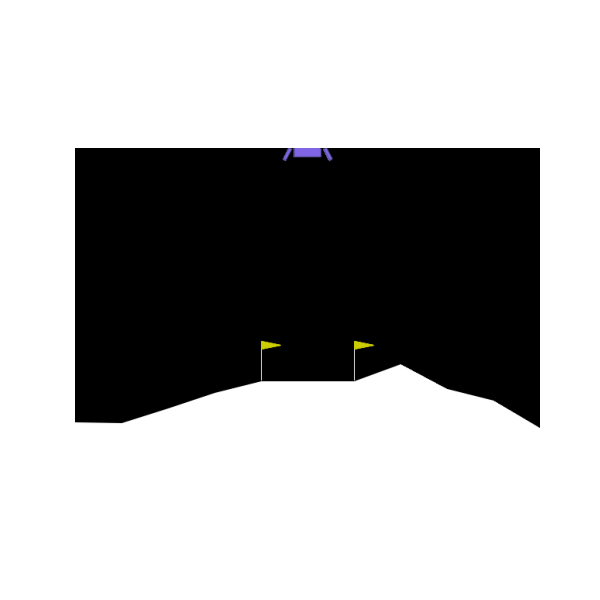

In [10]:
def visualize_best_model_with_gif_v2(model_path="best_dqn_lunarlander.pth", save_path="lander_best.gif", n_trials=5):
    env = gym.make("LunarLander-v3", render_mode="rgb_array")

    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n
    model = DQN(input_dim, output_dim).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    best_frames = None
    best_total_reward = -float('inf')

    for trial in range(n_trials):
        frames = []
        state, _ = env.reset()
        state = np.array(state)
        done = False
        total_reward = 0

        while not done:
            frame = env.render()
            frames.append(frame)

            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = model(state_tensor)
            action = torch.argmax(q_values, dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
            state = np.array(next_state)

        if total_reward > best_total_reward:
            best_total_reward = total_reward
            best_frames = frames
            print(f"New best flight found with reward {total_reward:.2f} at trial {trial+1}")

    env.close()

    if best_frames is None:
        print("No good flight found.")
        return

    fig = plt.figure(figsize=(6, 6))
    plt.axis('off')
    img = plt.imshow(best_frames[0])

    def animate(i):
        img.set_data(best_frames[i])
        return [img]

    ani = animation.FuncAnimation(fig, animate, frames=len(best_frames), interval=50, blit=True)
    ani.save(save_path, writer='pillow')
    print(f"Saved best flight as {save_path}")

    plt.close(fig)
    from IPython.display import Image
    display(Image(filename=save_path))

visualize_best_model_with_gif_v2(n_trials=5)